In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
#import the salinization wetland dataset
peat_cols = ['decday', 'datetime', 'wm_gf', 'wm', 'wc_gf', 'gpp_ANNnight', 'er_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'PRECIP', 'ustar', 'WT', 'H_gf', 'TW_WATER_10cm']

peat = pd.read_csv('data/peat6_all.csv', usecols=peat_cols, index_col='datetime', parse_dates=True)

In [191]:
def entropy(x, bins = 10):
    
    counts = x.value_counts(bins = bins)
    probs = counts / np.sum(counts)
    
    return - np.sum(probs * np.log2(probs))

def joint_entropy(x, y, bins = 10):
    
    x.reset_index(drop = True, inplace = True)
    y.reset_index(drop = True, inplace = True)
    combined = pd.concat([x, y], axis=1).dropna() #drop all rows with NA in both variables
    j_probs = pd.crosstab(pd.cut(combined.iloc[:, 0], bins = bins), 
                          pd.cut(combined.iloc[:, 1], bins = bins)) / len(combined)
    
    return - np.sum(np.sum(j_probs * np.log2(j_probs)))

def entropy_3d(x, y, z, bins = 10):
    
    combined = pd.concat([x, y, z], axis = 1).dropna()
    j_probs = pd.crosstab(pd.cut(combined.iloc[:, 0], bins = bins),
                          pd.cut(combined.iloc[:, 1], bins = bins),
                          pd.cut(combined.iloc[:, 2], bins = bins))
    
    return - np.sum(np.sum(j_probs * np.log2(j_probs)))

def mutual_information(x, y, bins = 10, normalize = True):
    
    Hx = entropy(x, bins = bins)
    Hy = entropy(y, bins = bins)
    Hxy = joint_entropy(x, y, bins = bins)
    
    if normalize == True:
        MI = (Hx + Hy - Hxy) / Hy
    else:
        MI = Hx + Hy - Hxy
        
    return MI

In [297]:
def MI_timeseries(x_var, y_var, bins = 10, normalize = True,
                  runs = 100, alpha = 0.05, MC_runs = True):
    
    #combine variables and create monthly stamp
    combined = pd.concat([x_var, y_var], axis=1).dropna()
    combined['Yr_mnth'] = combined.index.strftime('%Y%m')
    cols = combined.columns
    
    #subset data my month, calculate and save mutual information
    time_index = combined['Yr_mnth'].unique()
    MI_out = np.empty(len(time_index)) #empty MI array
    
    if MC_runs == True:
        MI_MC = np.empty([len(time_index), runs]) #raw MC runs matrix
    
    for i in range(len(time_index)):
        
        monthly = combined[combined.Yr_mnth == time_index[i]]
        MI_out[i] = mutual_information(monthly[cols[0]], monthly[cols[1]], 
                                       bins = bins, normalize=normalize)
        
        if MC_runs == True:
            
            for j in range(runs):
                x_shuffle = monthly[cols[0]].sample(len(monthly), replace = False) #shuffle x
                
                MI_MC[i, j] = mutual_information(x_shuffle, monthly[cols[1]], 
                                                 bins = bins, normalize = normalize)         
    
    if MC_runs == True:
        MI_MC = np.percentile(MI_MC, q = (1 - alpha) * 100, axis = 1)                
        return MI_out, MI_MC
    
    return MI_out

In [298]:
obs = peat['2012':'2017']
GPP_mi, GPP_mc = MI_timeseries(obs['gpp_ANNnight'], obs['wm'], MC_runs = True, runs = 10)
TA_mi, TA_mc = MI_timeseries(obs['TA.y'], obs['wm'], MC_runs = True, runs = 10)

/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  


Text(0.5,0,'Time')

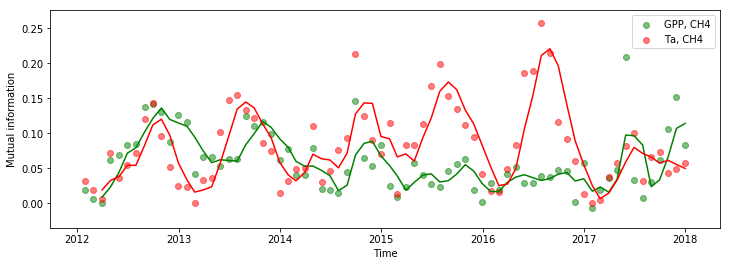

In [299]:
## Figure 1 in python
time = pd.date_range('2012', '2018', freq = 'M') #create time stamp

#corrected MI
GPP_mi_c = (GPP_mi - GPP_mc)
TA_mi_c = (TA_mi - TA_mc)

#plot it!
fig = plt.figure(figsize=(12, 4))
plt.scatter(time, GPP_mi_c, alpha = 0.5, color = 'green', label = 'GPP, CH4')
plt.scatter(time, TA_mi_c, alpha = 0.5, color = 'red', label = 'Ta, CH4')
plt.plot(time, pd.Series(GPP_mi_c).rolling(3).mean(), color = 'green')
plt.plot(time, pd.Series(TA_mi_c).rolling(3).mean(), color = 'red')
plt.legend()
plt.ylabel('Mutual information')
plt.xlabel('Time')


In [294]:
np.percentile(peat['wm_gf'], q = (1 - 0.01) * 100)


509.993245